In [228]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chardet
import pickle

In [229]:
DATA_DIR=os.path.join("data","ASCII")
ENCODING=None

In [230]:
len(os.listdir(DATA_DIR))

1560

In [429]:
try:
    with open(DATA_DIR+".pckl","rb") as f:
        data = pickle.load(f)
except:
    def read_file(path):
        data=[]
        in_data=False
        w=0
        h=0
        with open(path,"r",encoding=ENCODING) as f:
            for line in f.read().split("\n"):
                if line.startswith("ImageWidth="):
                    w=int(line.replace("ImageWidth=",""))
                if line.startswith("ImageHeight="):
                    h=int(line.replace("ImageHeight=",""))
                if line.startswith("[Data]"):
                    in_data=True
                    continue
                if in_data:
                    d=line.split("\t")[:w]
                    data.append(d)
                    if len(data)==h:
                        break
        data=np.array(data).astype(np.float)
        return data

    full_data={}
    for f in sorted(os.listdir(DATA_DIR)):
        print(f, end="\r")
        if f.endswith(".asc"):
            dd=full_data
            rec=f.split("_")
            for r in rec[-2:-1]:
                if r not in dd:
                    dd[r]={}
                dd=dd[r]

            datafile=os.path.join(DATA_DIR,f)

            if ENCODING is None:
                with open(datafile,"rb") as f:
                    ENCODING = chardet.detect(f.read())["encoding"]
            data = read_file(datafile)
            dd[rec[-1]]=data
    #        full_data.append(data)
    #full_data=np.array(full_data)
    #full_data

    l=sum([len(full_data[k]) for k in sorted(list(full_data))])

    print(l)
    s=next(iter(next(iter(full_data.values())).values())).shape
    print(s)
    data=np.zeros((l,*s),dtype=float)
    i=0
    for k in sorted(list(full_data)):
        for sk in sorted(list(full_data[k])):
            data[i]=full_data[k][sk]
            i+=1
    #    s = next(iter(full_data[k].values())).shape
    #    data=np.zeros((l,*s),dtype=float)
    #    for i,v in enumerate(full_data[k].values()):
    #        data[i]=v
    #    full_data[k]=data    

    with open(DATA_DIR+".pckl","w+b") as f:
        pickle.dump(data,f)
data.shape

(1560, 512, 640)

In [404]:
def normalize(data):
    ndata=data - data.min()
    ndata/=ndata.max()
    return ndata

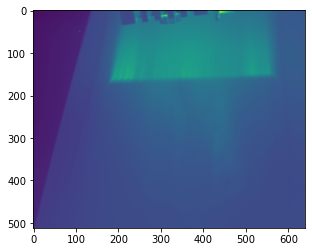

In [481]:
#plt.imshow(data[0,:,:])

sum_image=normalize(data.sum(0))
plt.imshow(sum_image)

[array([ 0.058, -0.277]), array([ 0.02272727, -0.27818182]), array([-0.01227573, -0.25212465])]


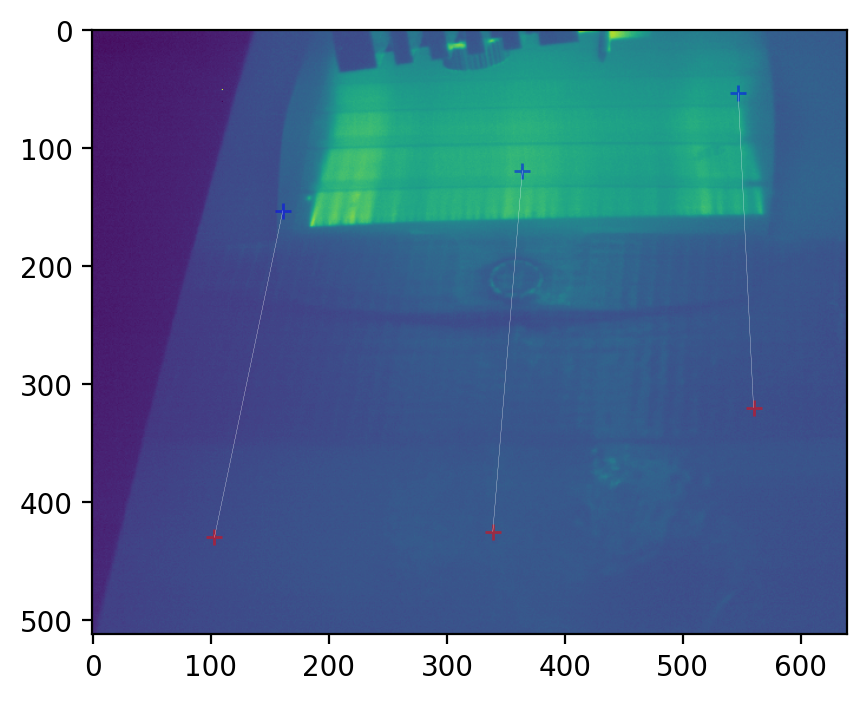

In [480]:
import matplotlib.patches as patches
pointmoves=(
    ((103,430,300,
     161,153,1300
     )),
      (339,425,400,
      364,119,1500
      ),
    (560,320,500,
      547,53,1559
      ),
      )
si=0
dp=1200

_d=np.log(data)

plt.figure(dpi=200)
plt.imshow(_d[dp])
speeds=[np.array([ex-sx,ey-sy])/(fe-fs) for sx,sy,fs,ex,ey,fe in pointmoves]
print(speeds)
for i in range(si,len(pointmoves)):
    sx,sy,fs,ex,ey,fe = pointmoves[i]
    plt.plot([sx], [sy],"+", linewidth=0.1,alpha=0.5, color='r')
    plt.plot([ex], [ey],"+", linewidth=0.1,alpha=0.5, color='b')
    plt.plot([sx,ex], [sy,ey], linewidth=0.1, color='w')

plt.show()
plt.close()

if si>0:
    for i in range(si,len(pointmoves)):
        sx,sy,fs,ex,ey,fe = pointmoves[i]
        plt.figure(dpi=200)
        plt.imshow(_d[fs,
                        max(0,sy-100):min(data.shape[1],sy+100),
                        max(0,sx-100):min(data.shape[2],sx+100),
                       ])
        plt.axvline(x=sx-max(0,sx-100),color='red',alpha=0.8,linewidth=0.1)
        plt.axhline(y=sy-max(0,sy-100),color='red',alpha=0.8,linewidth=0.1)
        plt.show()
        plt.close()

        plt.figure(dpi=200)
        plt.imshow(_d[fe,
                        max(0,ey-100):min(data.shape[1],ey+100),
                        max(0,ex-100):min(data.shape[2],ex+100),
                       ])
        plt.axvline(x=ex-max(0,ex-100),color='b',alpha=0.8,linewidth=0.1)
        plt.axhline(y=ey-max(0,ey-100),color='b',alpha=0.8,linewidth=0.1)
        plt.show()
        plt.close()

[[ 1.65263254e+00  4.28026255e-01 -2.07387179e+02]
 [ 1.05208739e-01  1.56988729e+00 -7.26777151e+01]
 [ 4.34073653e-04  8.86885881e-04  1.00000000e+00]]


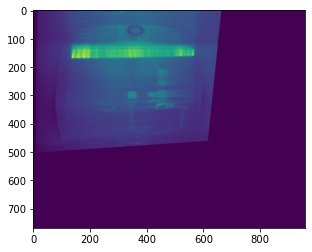

In [460]:
import cv2
speeds=[np.array([ex-sx,ey-sy])/(fe-fs) for sx,sy,fs,ex,ey,fe in pointmoves]
input_pts = np.float32([[sx,sy] for sx,sy,fs,ex,ey,fe in [pointmoves[0],pointmoves[-1]]]+[[ex,ey] for sx,sy,fs,ex,ey,fe in [pointmoves[0],pointmoves[-1]]])
output_pts = np.float32([[sx,sy] for sx,sy,fs,ex,ey,fe in [pointmoves[0],pointmoves[-1]]]+[[sx,ey] for sx,sy,fs,ex,ey,fe in [pointmoves[0],pointmoves[-1]]])
# Compute the perspective transform M
M = cv2.getPerspectiveTransform(input_pts,output_pts)
print(M)
# Apply the perspective transformation to the image
t_data = np.array([cv2.warpPerspective(d,M,(int(d.shape[1]*1.5),int(d.shape[0]*1.5)),flags=cv2.INTER_LINEAR) for d in data])
tr=data.mean()-data.std()
t_data[t_data<tr]=tr
plt.imshow(t_data[200])

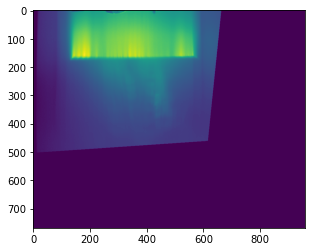

In [451]:
sum_image=normalize(t_data.sum(0))
plt.imshow(sum_image)

(0, 135, 172, 569)

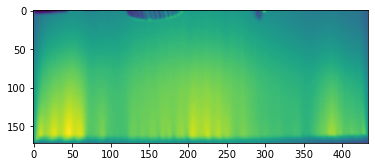

In [458]:
# get the area of the data where stuff happens
from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage

mask=normalize(gaussian_filter(sum_image, sigma=1))

mask[mask<0.60]=0
mask[mask>=0.60]=1
labeled_mask, cc_num = ndimage.label(mask)
#plt.imshow(labeled_mask)
largest_cc_mask = (labeled_mask == (np.bincount(labeled_mask.flat)[1:].argmax() + 1))
#plt.imshow(largest_cc_mask)
#plt.imshow(sum_image*largest_cc_mask)

largest_cc_mask=largest_cc_mask*1.0
largest_cc_mask[largest_cc_mask==0]=np.nan
coord_image=np.zeros((2,*sum_image.shape))
coord_image[0]=np.repeat(np.arange(coord_image.shape[1]),coord_image.shape[2]).reshape(coord_image.shape[1:])
coord_image[1]=np.tile(np.arange(coord_image.shape[2]),coord_image.shape[1]).reshape(coord_image.shape[1:])
#plt.imshow(coord_image[1,:,:]*largest_cc_mask)
max_x=int(np.nanmax(coord_image[0,:,:]*largest_cc_mask))
max_y=int(np.nanmax(coord_image[1,:,:]*largest_cc_mask))
min_x=int(np.nanmin(coord_image[0,:,:]*largest_cc_mask))
min_y=int(np.nanmin(coord_image[1,:,:]*largest_cc_mask))

plt.imshow(sum_image[min_x:max_x,min_y:max_y])
min_x,min_y, max_x,max_y

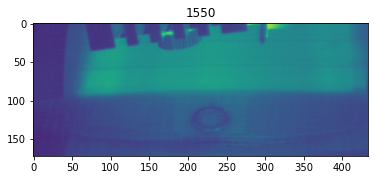

In [478]:
from IPython.core.display import clear_output
import time
_data=data[:,min_x:max_x,min_y:max_y].copy()
_ar=np.log(_data)
_ar[:,0,0]=_ar.max()
_ar[:,-1,-1]=_ar.min()
for i in range(0,len(_ar),10):
    #plt.figure(dpi=40)
    plt.imshow(_ar[i])
    
    #time.sleep(0.5)
#    plt.colorbar()
    plt.title(i)
    clear_output(wait=True)
    plt.show()
    plt.close()
    

In [12]:
def lucas_kanade_np(im1, im2, win=2):
    assert im1.shape == im2.shape
    I_x = np.zeros(im1.shape)
    I_y = np.zeros(im1.shape)
    I_t = np.zeros(im1.shape)
    I_x[1:-1, 1:-1] = (im1[1:-1, 2:] - im1[1:-1, :-2]) / 2
    I_y[1:-1, 1:-1] = (im1[2:, 1:-1] - im1[:-2, 1:-1]) / 2
    I_t[1:-1, 1:-1] = im1[1:-1, 1:-1] - im2[1:-1, 1:-1]
    params = np.zeros(im1.shape + (5,)) #Ix2, Iy2, Ixy, Ixt, Iyt
    params[..., 0] = I_x * I_x # I_x2
    params[..., 1] = I_y * I_y # I_y2
    params[..., 2] = I_x * I_y # I_xy
    params[..., 3] = I_x * I_t # I_xt
    params[..., 4] = I_y * I_t # I_yt
    del I_x, I_y, I_t
    cum_params = np.cumsum(np.cumsum(params, axis=0), axis=1)
    del params
    win_params = (cum_params[2 * win + 1:, 2 * win + 1:] -
                  cum_params[2 * win + 1:, :-1 - 2 * win] -
                  cum_params[:-1 - 2 * win, 2 * win + 1:] +
                  cum_params[:-1 - 2 * win, :-1 - 2 * win])
    del cum_params
    op_flow = np.zeros(im1.shape + (2,))
    det = win_params[...,0] * win_params[..., 1] - win_params[..., 2] **2
    op_flow_x = np.where(det != 0,
                         (win_params[..., 1] * win_params[..., 3] -
                          win_params[..., 2] * win_params[..., 4]) / det,
                         0)
    op_flow_y = np.where(det != 0,
                         (win_params[..., 0] * win_params[..., 4] -
                          win_params[..., 2] * win_params[..., 3]) / det,
                         0)
    op_flow[win + 1: -1 - win, win + 1: -1 - win, 0] = op_flow_x[:-1, :-1]
    op_flow[win + 1: -1 - win, win + 1: -1 - win, 1] = op_flow_y[:-1, :-1]
    return op_flow

In [21]:
def get_move_dir(data,start_frame,delta_frames,window,n_samples):
    lk = lucas_kanade_np(
        normalize(data[start_frame]),
        normalize(data[start_frame+delta_frames]),window)
    
    lk_lengths = np.sqrt(lk[:,:,0]*lk[:,:,0]+lk[:,:,1]*lk[:,:,1])
    
    _lk_lengths = normalize(gaussian_filter(lk_lengths, sigma=3))

    d_large=int(np.ceil(2*np.sqrt(np.prod(_lk_lengths.shape))/n_samples))
    #print(d_large)
    largest_points=np.zeros((n_samples,2),dtype=int)
    pinned_lk_lengths=_lk_lengths.copy()
    for i in range(n_samples):
        largest_points[i] = np.dstack(np.unravel_index(np.argmax(pinned_lk_lengths.ravel()),_lk_lengths.shape))[0,0]
        pinned_lk_lengths[
            max(0,largest_points[i,0]-d_large):min(_lk_lengths.shape[0],largest_points[i,0]+d_large),
            max(0,largest_points[i,1]-d_large):min(_lk_lengths.shape[1],largest_points[i,1]+d_large),
        ]=0



    move_dir=[
        -(lk[largest_points[:,0],largest_points[:,1],0]*lk_lengths[largest_points[:,0],largest_points[:,1]]).mean(),
        -(lk[largest_points[:,0],largest_points[:,1],1]*lk_lengths[largest_points[:,0],largest_points[:,1]]).mean()
    ]
    return np.array(move_dir)

In [27]:
#optimization
move_dirs=[]
move_dir_x=np.arange(3970,3980,1)
for n in move_dir_x:
    print(n,end="\r")
    d= get_move_dir(
        data[:,min_x:max_x,min_y:max_y],
        start_frame=200,
        delta_frames=50,
        window=11,
        n_samples=n,
    )
    move_dirs.append(d)
move_dirs=np.array(move_dirs)

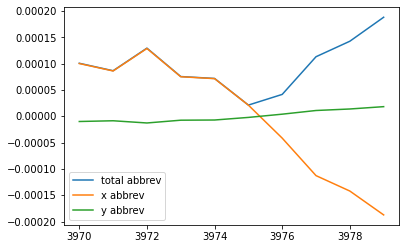

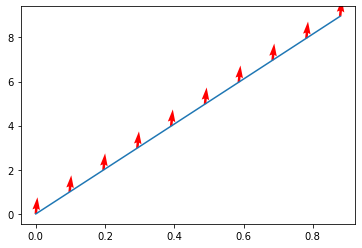

In [28]:
dir_lengths=np.linalg.norm(move_dirs,axis=1)
n_move_dirs=move_dirs.copy()
n_move_dirs[:,0]/=dir_lengths
n_move_dirs[:,1]/=dir_lengths

mean_dir=n_move_dirs.mean(axis=0)

diff_dir=n_move_dirs-mean_dir
l_diff_dir=np.linalg.norm(diff_dir,axis=1)
plt.plot(move_dir_x,l_diff_dir,label="total abbrev")
plt.plot(move_dir_x,diff_dir[:,0],label="x abbrev")
plt.plot(move_dir_x,diff_dir[:,1],label="y abbrev")
plt.legend()
plt.show()
plt.close()

pos=np.zeros(move_dirs.shape)
n_move_dirs=move_dirs.copy()
n_move_dirs[:,0]/=dir_lengths
n_move_dirs[:,1]/=dir_lengths
pos[1:,0]=np.cumsum(n_move_dirs[:,0])[:-1]
pos[1:,1]=np.cumsum(n_move_dirs[:,1])[:-1]
plt.quiver(pos[:,0],
       pos[:,1],
       n_move_dirs[:,0],
       n_move_dirs[:,1],
       color="r",scale=20)
plt.plot(pos[:,0],
       pos[:,1])
plt.show()
plt.close()

In [128]:
move_dir = get_move_dir(
        data[:,min_x:max_x,min_y:max_y],
        start_frame=200,
        delta_frames=50,
        window=11,
        n_samples=3975,
    )/50
move_dir

array([0.07480153, 0.76236402])

In [124]:
_nd=np.zeros_like(_data)*np.nan
_nd[0]=_data[0]

for i in range(1,len(_nd)):
    #print(i, min(_nd.shape[1],int(move_dir[0]*i)),min(_nd.shape[2],int(move_dir[1]*i)))
    _nd[i,min(_nd.shape[1],int(move_dir[0]*i)):,min(_nd.shape[2],int(move_dir[1]*i)):]=_data[i,min(_nd.shape[1],int(move_dir[0]*i)):,min(_nd.shape[2],int(move_dir[1]*i)):]
   

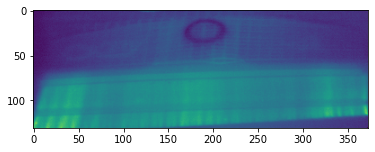

In [125]:
plt.imshow(_data[300])

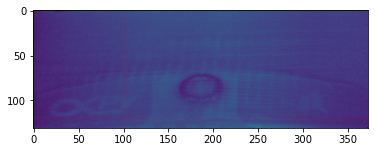

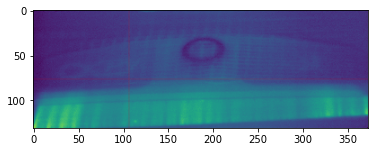

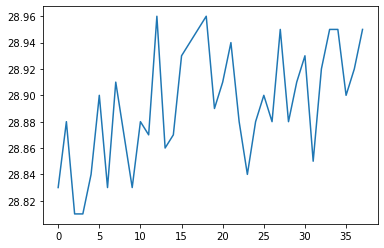

In [225]:
x,y=(102,120)
sp=10

pd=[]
i=sp
nx=x
ny=y
plt.imshow(_data[i])
plt.axvline(x=nx,color='red',alpha=0.1)
plt.axhline(y=ny,color='red',alpha=0.1)
plt.show()
plt.close()
for i in range(sp,sp+190,5):#len(_data)
    try:
        nx=x+int(move_dir[0]/3 *(i-sp))
        ny=y-int(move_dir[1]/3.2 *(i-sp))
        if nx<0 or ny<0:
            continue
        pd.append(_data[i,ny,nx])
        
    except IndexError:
        continue
plt.imshow(_data[i])
plt.axvline(x=nx,color='red',alpha=0.1)
plt.axhline(y=ny,color='red',alpha=0.1)

plt.show()
plt.close()

plt.plot(pd)
plt.show()
plt.close()
#clear_output(wait=True)

## for i in range(0,len(_nd),1):
    #plt.figure(dpi=40)
    plt.imshow(_nd[i])
    
    #time.sleep(0.5)
    plt.colorbar()
    clear_output(wait=True)
    plt.show()
    plt.close()
    

In [324]:
(0.55935741*0.55935741+0.82892659*0.82892659)**0.5

1.0000000018654682

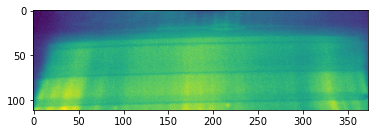

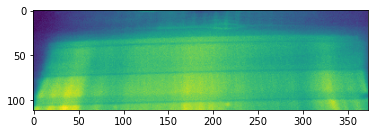

In [230]:
i=500
k=5
ini_diff=20
lk = lucas_kanade_np(normalize(data[i,min_x:max_x-ini_diff,min_y:max_y]),normalize(data[i+k,min_x:max_x-ini_diff,min_y:max_y]),3)
plt.imshow(normalize(data[i,min_x:max_x-ini_diff,min_y:max_y]))
plt.show()
plt.close()
plt.imshow(normalize(data[i+k,min_x:max_x-ini_diff,min_y:max_y]))
plt.show()
plt.close()

In [20]:
lk_lengths = np.sqrt(lk[:,:,0]*lk[:,:,0]+lk[:,:,1]*lk[:,:,1])
plt.imshow(lk_lengths)

NameError: name 'lk' is not defined

0.08068748846974459 1.1032989579961063


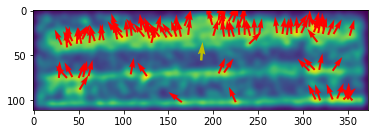

In [240]:
_lk_lengths = normalize(gaussian_filter(lk_lengths, sigma=3))
#plt.imshow(_lk_lengths)


largestn=100
d_large=5
largest_points=np.zeros((largestn,2),dtype=int)
pinned_lk_lengths=_lk_lengths.copy()
for i in range(largestn):
    largest_points[i] = np.dstack(np.unravel_index(np.argmax(pinned_lk_lengths.ravel()),_lk_lengths.shape))[0,0]
    pinned_lk_lengths[
        max(0,largest_points[i,0]-d_large):min(_lk_lengths.shape[0],largest_points[i,0]+d_large),
        max(0,largest_points[i,1]-d_large):min(_lk_lengths.shape[1],largest_points[i,1]+d_large),
    ]=0



move_dir=[
    -(lk[largest_points[:,0],largest_points[:,1],0]*lk_lengths[largest_points[:,0],largest_points[:,1]]).mean(),
    -(lk[largest_points[:,0],largest_points[:,1],1]*lk_lengths[largest_points[:,0],largest_points[:,1]]).mean()
]

plt.imshow(_lk_lengths)

plt.quiver(largest_points[:,1],
           largest_points[:,0],
           lk[largest_points[:,0],largest_points[:,1],0],
           -lk[largest_points[:,0],largest_points[:,1],1],
           color="r",scale=20*lk_lengths[largest_points[:,0],largest_points[:,1]])

plt.quiver(_lk_lengths.shape[1]/2,
           _lk_lengths.shape[0]/2,
           move_dir[0],
           move_dir[1],
           color="y",scale=20
          )
print(move_dir[0],
     move_dir[1]
     )

plt.show()
plt.close()
#print(largest_points)
#lk_lengths.shape
#origin = np.array([[0, 0, 0],[0, 0, 0]])
#plt.quiver(*origin, V[:,0], V[:,1], color=['r','b','g'], scale=21)

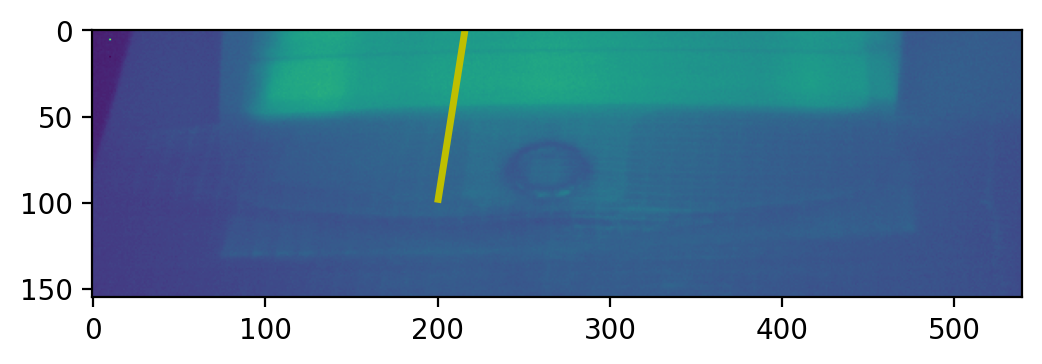

In [323]:
data[:,50,110]=data.max()
data[:,60,110]=data.min()
for i in range(0,len(data),20):
    plt.figure(dpi=200)
    plt.imshow(data[i,45:200,100:])
    plt.quiver(200,
           100,
         1.6719289531857733,
               10.557989774909524,
           color="y",scale=1
          )
    
  #  #time.sleep(0.5)
    #plt.colorbar()
    clear_output(wait=True)
    plt.show()
    plt.close()
    

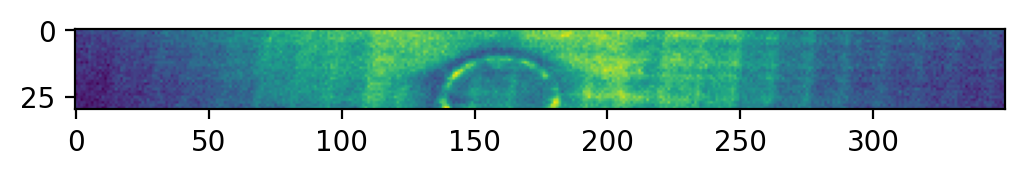

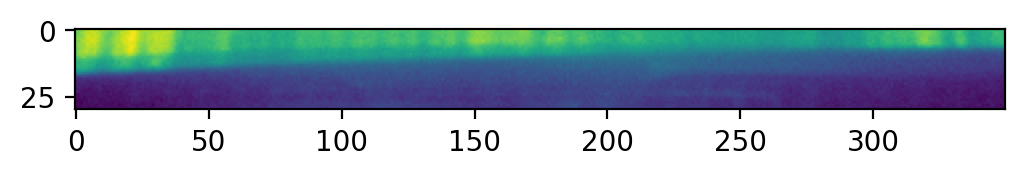

In [ ]:
R=30
D=30
S=120
for i in range(0,len(data),20):
    
    plt.figure(dpi=200)
    plt.imshow(data[i,S+D*2:S+D*2+R,200:550])
    plt.show()
    plt.close()
    
    plt.figure(dpi=200)
    plt.imshow(data[i,S+D:S+D+R,200:550])
    plt.show()
    plt.close()
    
    
    time.sleep(0.5)
    clear_output(wait=True)
    
    

In [147]:
def lucas_kanade_np(im1, im2, win=2):
    assert im1.shape == im2.shape
    I_x = np.zeros(im1.shape)
    I_y = np.zeros(im1.shape)
    I_t = np.zeros(im1.shape)
    I_x[1:-1, 1:-1] = (im1[1:-1, 2:] - im1[1:-1, :-2]) / 2
    I_y[1:-1, 1:-1] = (im1[2:, 1:-1] - im1[:-2, 1:-1]) / 2
    I_t[1:-1, 1:-1] = im1[1:-1, 1:-1] - im2[1:-1, 1:-1]
    params = np.zeros(im1.shape + (5,)) #Ix2, Iy2, Ixy, Ixt, Iyt
    params[..., 0] = I_x * I_x # I_x2
    params[..., 1] = I_y * I_y # I_y2
    params[..., 2] = I_x * I_y # I_xy
    params[..., 3] = I_x * I_t # I_xt
    params[..., 4] = I_y * I_t # I_yt
    del I_x, I_y, I_t
    cum_params = np.cumsum(np.cumsum(params, axis=0), axis=1)
    del params
    win_params = (cum_params[2 * win + 1:, 2 * win + 1:] -
                  cum_params[2 * win + 1:, :-1 - 2 * win] -
                  cum_params[:-1 - 2 * win, 2 * win + 1:] +
                  cum_params[:-1 - 2 * win, :-1 - 2 * win])
    del cum_params
    op_flow = np.zeros(im1.shape + (2,))
    det = win_params[...,0] * win_params[..., 1] - win_params[..., 2] **2
    op_flow_x = np.where(det != 0,
                         (win_params[..., 1] * win_params[..., 3] -
                          win_params[..., 2] * win_params[..., 4]) / det,
                         0)
    op_flow_y = np.where(det != 0,
                         (win_params[..., 0] * win_params[..., 4] -
                          win_params[..., 2] * win_params[..., 3]) / det,
                         0)
    op_flow[win + 1: -1 - win, win + 1: -1 - win, 0] = op_flow_x[:-1, :-1]
    op_flow[win + 1: -1 - win, win + 1: -1 - win, 1] = op_flow_y[:-1, :-1]
    return op_flow

def optical_flow(I1g, I2g, window_size, tau=1e-2):

    kernel_x = np.array([[-1., 1.], [-1., 1.]])
    kernel_y = np.array([[-1., -1.], [1., 1.]])
    kernel_t = np.array([[1., 1.], [1., 1.]])#*.25
    w = int(window_size/2) # window_size is odd, all the pixels with offset in between [-w, w] are inside the window
    I1g = I1g / 255. # normalize pixels
    I2g = I2g / 255. # normalize pixels
    # Implement Lucas Kanade
    # for each point, calculate I_x, I_y, I_t
    mode = 'same'
    fx = signal.convolve2d(I1g, kernel_x, boundary='symm', mode=mode)
    fy = signal.convolve2d(I1g, kernel_y, boundary='symm', mode=mode)
    ft = signal.convolve2d(I2g, kernel_t, boundary='symm', mode=mode) + signal.convolve2d(I1g, -kernel_t, boundary='symm', mode=mode)
    u = np.zeros(I1g.shape)
    v = np.zeros(I1g.shape)
    # within window window_size * window_size
    for i in range(w, I1g.shape[0]-w):
        for j in range(w, I1g.shape[1]-w):
            Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            It = ft[i-w:i+w+1, j-w:j+w+1].flatten()
            #b = ... # get b here
            #A = ... # get A here
            # if threshold τ is larger than the smallest eigenvalue of A'A:
            nu = ... # get velocity here
            u[i,j]=nu[0]
            v[i,j]=nu[1]

    return (u,v)